In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# (Run this cell and follow the prompt to allow Drive access)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

dataset_path = '/content/drive/MyDrive/animals'  
print("Dataset path:", dataset_path)
print("Folders:", os.listdir(dataset_path))
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    print(cls, "->", len(os.listdir(cls_path)), "images (showing up to 5):", os.listdir(cls_path)[:5])

Dataset path: /content/drive/MyDrive/animals
Folders: ['dogs', 'panda', 'cats']
dogs -> 150 images (showing up to 5): ['dogs_00120.jpg', 'dogs_00017.jpg', 'dogs_00080.jpg', 'dogs_00026.jpg', 'dogs_00057.jpg']
panda -> 150 images (showing up to 5): ['panda_00028.jpg', 'panda_00025.jpg', 'panda_00012.jpg', 'panda_00006.jpg', 'panda_00013.jpg']
cats -> 150 images (showing up to 5): ['cats_00001.jpg', 'cats_00004.jpg', 'cats_00002.jpg', 'cats_00003.jpg', 'cats_00005.jpg']


In [ ]:
# NeuralNetwork class (Conv -> Flatten -> 2 hidden Dense -> output)
class NeuralNetwork:
    def __init__(self, input_shape=(64,64,3), num_classes=3, hidden1=64, hidden2=32, lr=1e-3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.lr = lr
        self.model = self.build_model()
    def build_model(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D((2,2)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D((2,2)),
            Flatten(),
            Dense(self.hidden1, activation='relu'),   # hidden layer 1
            Dropout(0.4),
            Dense(self.hidden2, activation='relu'),   # hidden layer 2
            Dropout(0.3),
            Dense(self.num_classes, activation='softmax')
        ])
        return model
    def compile(self):
        opt = Adam(learning_rate=self.lr)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    def train(self, train_gen, val_gen, epochs=10):
        history = self.model.fit(train_gen, validation_data=val_gen, epochs=epochs)
        return history
    def save(self, path):
        self.model.save(path)

In [ ]:
# Data generators and training 
img_h, img_w = 64, 64
batch_size = 16
epochs = 8          
classes = ['dogs','cats','panda']   

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    subset='training',
    shuffle=True, seed=100
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    subset='validation',
    shuffle=False, seed=100
)

# Model,compile ও train
NN = NeuralNetwork(input_shape=(img_h,img_w,3), num_classes=len(classes), hidden1=128, hidden2=64, lr=1e-3)
NN.compile()
NN.model.summary()

history = NN.train(train_gen, val_gen, epochs=epochs)

Found 360 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633,603 (6.23 MB)

 Trainable params: 1,633,603 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.3451 - loss: 1.1738 - val_accuracy: 0.3333 - val_loss: 1.0663
Epoch 2/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.4180 - loss: 1.0395 - val_accuracy: 0.4598 - val_loss: 0.9676
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.5241 - loss: 0.9525 - val_accuracy: 0.5402 - val_loss: 0.8775
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.6209 - loss: 0.8563 - val_accuracy: 0.5862 - val_loss: 0.8007
Epoch 5/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.6579 - loss: 0.7069 - val_accuracy: 0.6092 - val_loss: 0.7649
Epoch 6/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.6581 - loss: 0.7140 - val_accuracy: 0.6207 - val_loss: 0.7472
Epoch 7/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.7059 - loss: 0.5904 - val_accuracy: 0.6092 - val_loss: 0.7173
Epoch 8/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7958 - loss: 0.4883 - val_accuracy: 0.6207 - v

Model saved to: /content/drive/MyDrive/animals_simple_model.h5


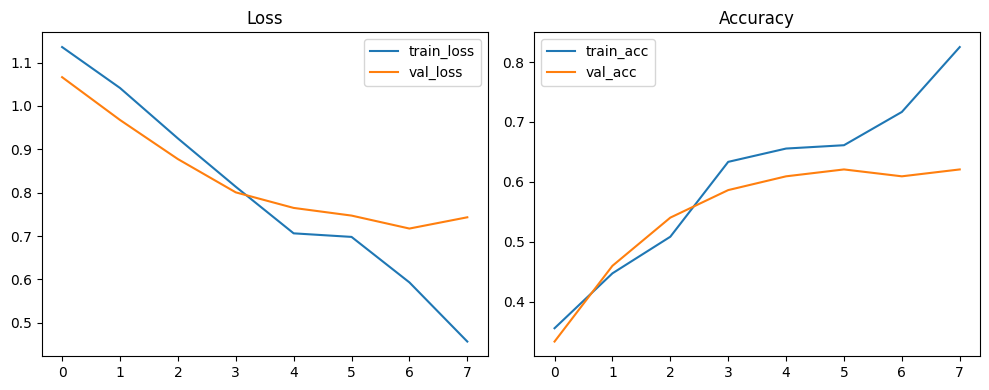

In [ ]:
# CELL 5 — Save model ও training plot 
save_path = '/content/drive/MyDrive/animals_simple_model.h5'
NN.save(save_path)
print("Model saved to:", save_path)

# Plot history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()

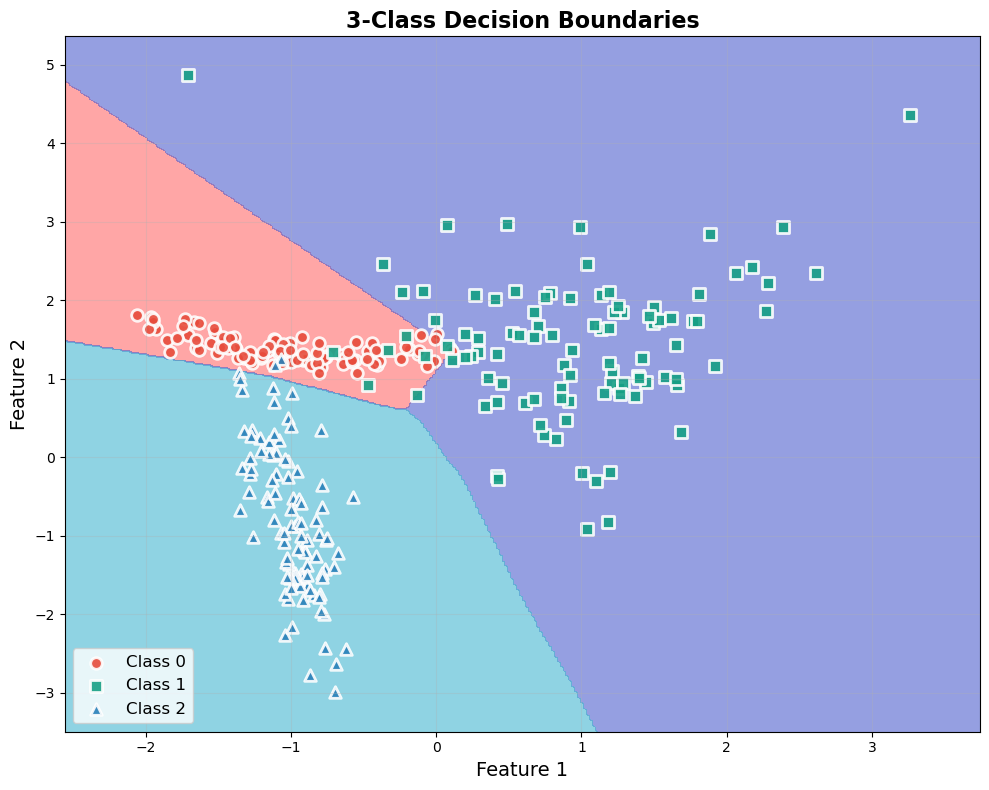

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

# Generate 3-class sample data
np.random.seed(42)
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, 
                          n_informative=2, random_state=42, n_clusters_per_class=1,
                          n_classes=3)

# Add some non-linearity
X[:, 1] = X[:, 1] + 0.3 * X[:, 0] ** 2

# Train neural network
mlp = MLPClassifier(hidden_layer_sizes=(20, 15), max_iter=2000, random_state=42)
mlp.fit(X, y)

# Create single 3-class decision boundary plot
def plot_single_3class_boundary():
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Three distinct colors for regions
    colors = ['#FF6B6B', "#4E5FCD", '#45B7D1']  # Red, Teal, Blue
    
    plt.figure(figsize=(10, 8))
    
    # Plot decision regions
    for i, color in enumerate(colors):
        plt.contourf(xx, yy, Z, levels=[i-0.5, i+0.5], colors=[color], alpha=0.6)
    
    # Plot data points with different shapes for each class
    shapes = ['o', 's', '^']  # circle, square, triangle
    colors_dark = ['#E74C3C', '#16A085', '#2980B9']  # Darker versions
    
    for class_value in np.unique(y):
        mask = y == class_value
        plt.scatter(X[mask, 0], X[mask, 1], 
                   c=colors_dark[class_value], 
                   marker=shapes[class_value],
                   s=70, 
                   edgecolors='white', 
                   linewidth=2,
                   label=f'Class {class_value}',
                   alpha=0.9)
    
    plt.xlabel('Feature 1', fontsize=14)
    plt.ylabel('Feature 2', fontsize=14)
    plt.title('3-Class Decision Boundaries', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the single plot
plot_single_3class_boundary()